In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from math import sqrt
import csv
from pickle import dump
from sklearn.model_selection import GroupShuffleSplit
from keras.utils.vis_utils import plot_model

clear_session()

In [2]:
def compute_metrics(pred,y_test):

    #print(pred)
    #print(y_test)
    diff = pred - y_test
    percentDiff = (diff / y_test) * 100
    
    #METRICS
    AbsPercentDiff = np.abs(percentDiff)
    MeanAPD = np.mean(AbsPercentDiff)
    StdAPD = np.std(AbsPercentDiff)
    
    CCTest  = pearsonr(y_test,pred)   #it should be the same thing of MATLAB 'corr' 
    RmseTest  = sqrt(mean_squared_error(y_test,pred))
    SITest  = sqrt(mean_squared_error(y_test,pred))/np.mean(y_test)
    BiasTest  = np.sum(pred-y_test)/y_test.shape[0]

    #print(CCTest[0],RmseTest,SITest,BiasTest,MeanAPD,StdAPD)
    return [CCTest[0],RmseTest,SITest,BiasTest,MeanAPD,StdAPD]

In [3]:
'''fixing seed'''
seed_value = 2

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
random_state = seed_value
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:

#WORKING DIRECTORY
path = Path.cwd()
save_path = Path(path / 'Ann_model_LSTM')

parent_path =  path.parent

#DATA LOADING
data = pd.read_excel(parent_path / 'dataset\Simulated_Dataset.xlsx', header=1)

  
#variables to consider
feat = ['Influent Flow',
'Influent pH',
'Biofor DN Temperature',
'Biofor CN - Dissolved oxygen',
'Effluent Flow',
'Effluent pH']

data = data.rename(columns={"Effluent BOD" : "BOD", "Effluent COD" : "COD","Effluent Total suspended solids": "TSS"})
targets = list(data.columns[-3:])
Test=data
data['new_date'] = [d.date() for d in data['Date']]
dt = data['new_date']

day = pd.Timedelta(1, "d")
breaks_day = dt.diff() >= day 
data['grp_date'] = breaks_day.cumsum()

BOD     4.387289
COD    14.313384
TSS     6.252489
dtype: float64
BOD    1.969279
COD    5.105597
TSS    1.387212
dtype: float64


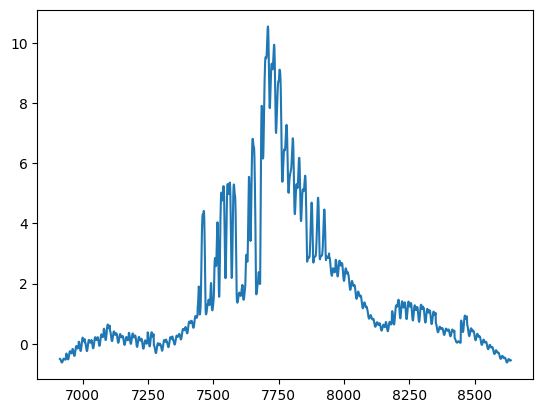

In [5]:
n = len(data)
train = data[0:int(n*0.7)]
val = data[int(n*0.7):int(n*0.8)]
test = data[int(n*0.8):]

sel = feat+targets
train_df = train[sel]
val_df = val[sel]
test_df = test[sel]
Total=data[sel]

train_mean = train_df.mean()
print(train_mean[6:9])

train_std = train_df.std()
print(train_std[6:9])

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
Total_df=(Total- train_mean) / train_std

num_features = train_df.shape[1]

plt.plot(test_df["COD"])

In [6]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}                                        

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [7]:
OUT_STEPS = 24
wide_window = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=6,
    label_columns=targets)

print(wide_window)

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Label column name(s): ['BOD', 'COD', 'TSS']


In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
    
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

In [9]:
WindowGenerator.split_window = split_window

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(test_df[0:0+wide_window.total_window_size]),
                           np.array(test_df[820:820+wide_window.total_window_size]),
                           np.array(test_df[1200:1200+wide_window.total_window_size])])

example_inputs, example_labels = wide_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

wide_window.example = example_inputs, example_labels

All shapes are: (batch, time, features)
Window shape: (3, 30, 9)
Inputs shape: (3, 24, 9)
Labels shape: (3, 24, 3)


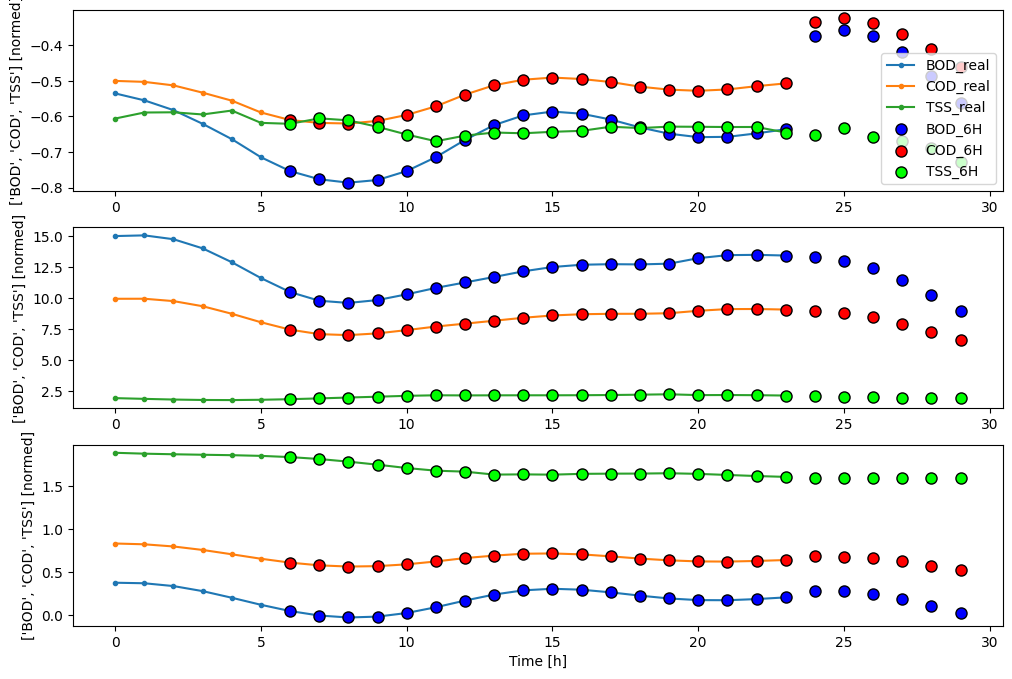

In [10]:
def plot(self, model=None, plot_col=targets[0:3], max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  #print(plot_col)
  plot_col_index0 = self.column_indices[plot_col[0]]
  plot_col_index1 = self.column_indices[plot_col[1]]
  plot_col_index2 = self.column_indices[plot_col[2]]
  #print(plot_col_index0, plot_col_index1, plot_col_index2)
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index0],
             label='BOD_real', marker='.', zorder=-10)
    plt.plot(self.input_indices, inputs[n, :, plot_col_index1],
             label='COD_real', marker='.', zorder=-10)
    plt.plot(self.input_indices, inputs[n, :, plot_col_index2],
             label='TSS_real', marker='.', zorder=-10)
    
    if self.label_columns:
      label_col_index0 = self.label_columns_indices.get(plot_col[0], None)
      label_col_index1 = self.label_columns_indices.get(plot_col[1], None)
      label_col_index2 = self.label_columns_indices.get(plot_col[2], None)
    else:
      label_col_index0 = plot_col_index0
      label_col_index1 = plot_col_index1
      label_col_index2 = plot_col_index2

    if label_col_index0 is None and label_col_index1 is None and label_col_index2 is None:
      continue


    plt.scatter(self.label_indices, labels[n, :, label_col_index0],
                edgecolors='k', label='BOD_6H', c='#0000FF', s=64)
    plt.scatter(self.label_indices, labels[n, :, label_col_index1],
                edgecolors='k', label='COD_6H', c='#FF0000', s=64)
    plt.scatter(self.label_indices, labels[n, :, label_col_index2],
                edgecolors='k', label='TSS_6H', c='#00FF00', s=64)
    
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index0],
                  marker='X', edgecolors='k', label='BOD_pred', c='#0000FF', s=64)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index1],
                  marker='X', edgecolors='k', label='COD_pred', c='#FF0000', s=64)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index2],
                  marker='X', edgecolors='k', label='TSS_pred', c='#00FF00', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot
wide_window.plot()


In [11]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32)

  ds = ds.map(self.split_window)
  
  return ds

WindowGenerator.make_dataset = make_dataset

In [12]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example_window

wide_window.train.element_spec

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 24, 9)
Labels shape (batch, time, features): (32, 24, 3)


In [13]:
MAX_EPOCHS = 100
def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  model.save(save_path)
  return history


In [14]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*3,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS,3])
])


In [15]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    #tf.keras.layers.LSTM(4096, return_sequences=False),
    tf.keras.layers.LSTM(256, return_sequences=False),
    tf.keras.layers.Dense(72),
    #tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(72),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*3,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 3])
])

In [16]:
history = compile_and_fit(multi_lstm_model, wide_window)

Epoch 1/100
189/189 [==============================] - 8s 33ms/step - loss: 0.1028 - mean_absolute_error: 0.1783 - val_loss: 0.0262 - val_mean_absolute_error: 0.1225
Epoch 2/100
189/189 [==============================] - 5s 28ms/step - loss: 0.0362 - mean_absolute_error: 0.1111 - val_loss: 0.0246 - val_mean_absolute_error: 0.1180
Epoch 3/100
189/189 [==============================] - 5s 27ms/step - loss: 0.0298 - mean_absolute_error: 0.1010 - val_loss: 0.0169 - val_mean_absolute_error: 0.0973
Epoch 4/100
189/189 [==============================] - 5s 27ms/step - loss: 0.0215 - mean_absolute_error: 0.0876 - val_loss: 0.0168 - val_mean_absolute_error: 0.0968
Epoch 5/100
189/189 [==============================] - 5s 28ms/step - loss: 0.0178 - mean_absolute_error: 0.0809 - val_loss: 0.0137 - val_mean_absolute_error: 0.0874
Epoch 6/100
189/189 [==============================] - 5s 28ms/step - loss: 0.0164 - mean_absolute_error: 0.0754 - val_loss: 0.0162 - val_mean_absolute_error: 0.1005
Epoc

INFO:tensorflow:Assets written to: c:\Users\MacGy\Downloads\Forecasting_WWTP-main\Forecasting_WWTP-main\code\Ann_model_LSTM\assets


INFO:tensorflow:Assets written to: c:\Users\MacGy\Downloads\Forecasting_WWTP-main\Forecasting_WWTP-main\code\Ann_model_LSTM\assets


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


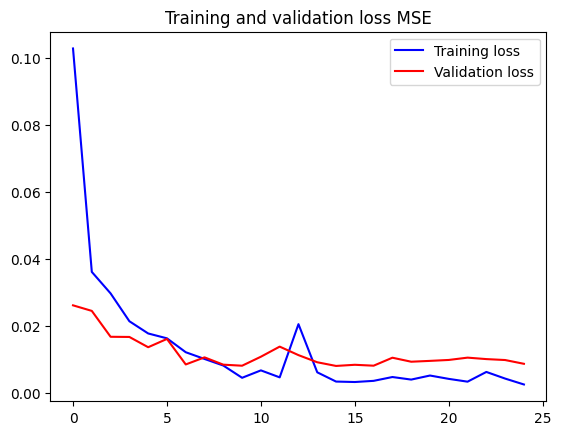

In [17]:
#PLOT TRAINING CURVES
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss MSE')
plt.legend()
plot_model(multi_lstm_model, show_shapes=True, show_layer_names=True)


27/27 [==============================] - 0s 11ms/step - loss: 0.0088 - mean_absolute_error: 0.0614


array([[[ 3.0485969 ,  3.1222327 ,  2.4415925 ],
        [ 3.408444  ,  3.3409927 ,  2.5090082 ],
        [ 3.9492683 ,  3.640849  ,  2.5530999 ],
        ...,
        [ 3.0741427 ,  3.185698  ,  2.3167915 ],
        [ 2.9188044 ,  3.1327565 ,  2.406812  ],
        [ 3.0258927 ,  3.2209518 ,  2.4938686 ]],

       [[ 4.0429273 ,  3.425985  ,  1.0335792 ],
        [ 4.2078347 ,  3.5479102 ,  1.1323515 ],
        [ 4.713276  ,  3.841073  ,  1.2035152 ],
        ...,
        [ 7.8093104 ,  5.6764827 ,  1.2062932 ],
        [ 7.3690586 ,  5.462981  ,  1.2517095 ],
        [ 7.0530562 ,  5.322147  ,  1.3170358 ]],

       [[-0.09181534,  0.2515163 ,  0.6426586 ],
        [-0.2889856 ,  0.13420537,  0.6184724 ],
        [-0.42663726,  0.05388831,  0.59133947],
        ...,
        [ 0.95423645,  0.80596745,  0.5649607 ],
        [ 0.90478396,  0.77153593,  0.55587137],
        [ 0.7517383 ,  0.68014205,  0.5449902 ]],

       ...,

       [[ 2.7269018 ,  2.502848  ,  0.821629  ],
        [ 3

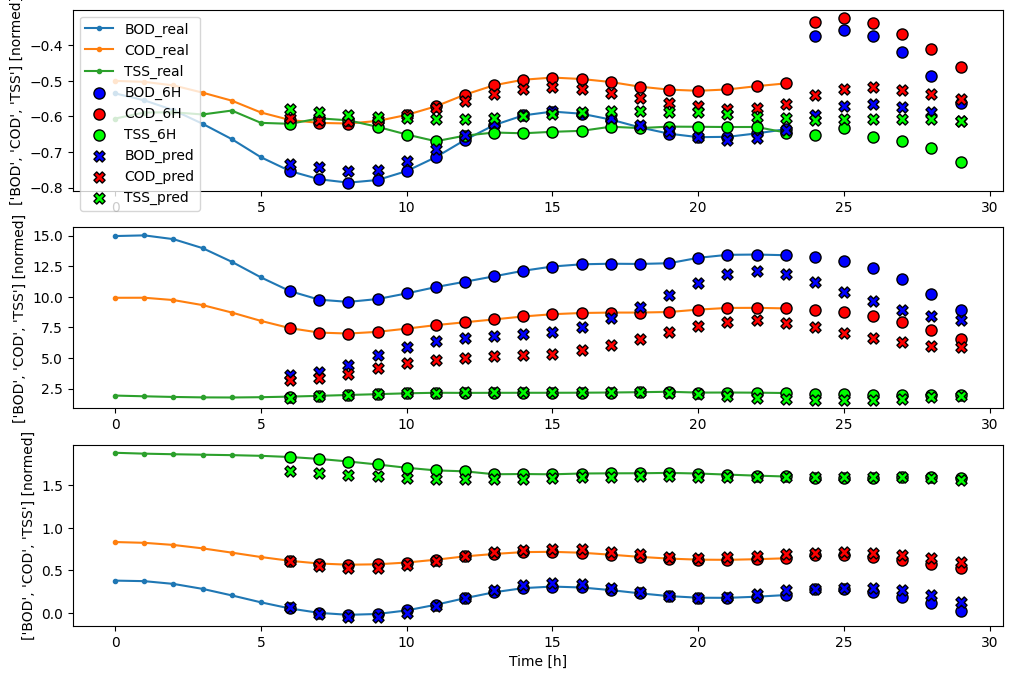

In [18]:
val_performance = multi_lstm_model.evaluate(wide_window.val)
performance = multi_lstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(multi_lstm_model)

predictions = multi_lstm_model.predict(wide_window.test, verbose=0)
predictions

[[5.947952  5.94065   5.90453   5.902973  5.886444  5.8835406 5.882821
  5.881053  5.8544993 5.821853  5.795543  5.7769766 5.77336   5.790344
  5.8138576 5.846316  5.8637047 5.882264  5.894742  5.8974676 5.9006276
  5.8942184 5.8906054 5.900314 ]
 [9.008329  8.961689  8.951206  8.999901  8.976746  8.9461565 8.914355
  8.88888   8.864763  8.85041   8.840893  8.833192  8.826117  8.815046
  8.795541  8.764499  8.722359  8.67352   8.619885  8.5773115 8.561728
  8.514418  8.517945  8.513406 ]
 [7.1746473 7.1972833 7.229566  7.2662416 7.2963896 7.321622  7.3520174
  7.371332  7.3900776 7.4012012 7.410028  7.41833   7.427367  7.4349456
  7.425892  7.4157596 7.412019  7.4095483 7.40312   7.386313  7.3630247
  7.334445  7.2864265 7.2786064]]
----------------------------------------------------------------------
[ 0.59449679  0.18370124  0.02204521 -0.03505553  1.96058791  0.93711084]


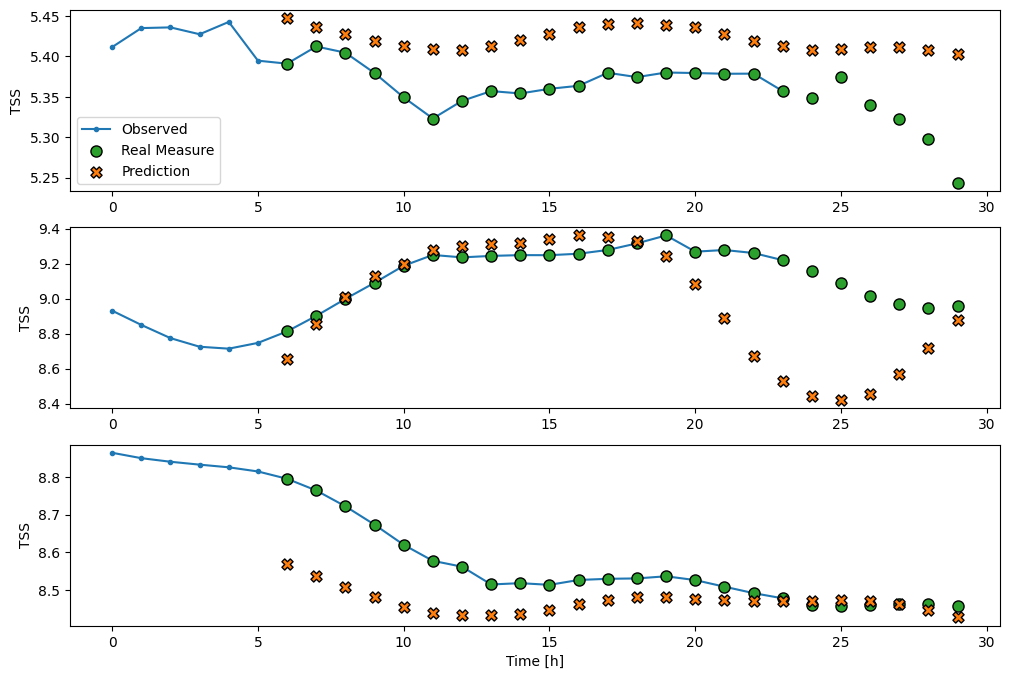

In [19]:
res = []
res_round = []

for inputs, labels in wide_window.test:
      labels = np.array(labels[:, :, -1])
      labels = labels*train_std['TSS']+train_mean['TSS']

      
      pred = multi_lstm_model(inputs)
      pred = np.array(pred[:, :, -1])
      pred = pred*train_std['TSS']+train_mean['TSS']

      for i in range(pred.shape[0]):
          res.append(compute_metrics(pred[i,:],labels[i,:].reshape(-1)))
          #res_round.append(compute_metrics(pred[i,:].round(),labels[i,:].reshape(-1).round()))

mean_res = np.mean(res, axis=0)
print(labels)
#mean_res_round = np.mean(res_round, axis=0)

print('----------------------------------------------------------------------')
print(mean_res)

wind_res = []
def plot_notscal(self, mean, std, wind_res, model=None, plot_col=targets[2], max_subplots=3):
  inputs, labels = self.example
  inputs_notscal = inputs*std+mean
  labels = labels*std+mean
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs_notscal[n, :, plot_col_index],
             label='Observed', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Real Measure', c='#2ca02c', s=64)
    if model is not None:
      preds = model(inputs)
      preds = preds*std+mean
      plt.scatter(self.label_indices, preds[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Prediction',
                  c='#ff7f0e', s=64)
      
      preds = np.array(preds[:, :, -1])

    #for i in range(preds.shape[0]):
     #     wind_res.append(compute_metrics(np.array(preds[i,:]),np.array(labels[i,:]).reshape(-1)))
    
    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot_notscal = plot_notscal
wide_window.plot_notscal(train_mean['TSS'],train_std['TSS'], wind_res, multi_lstm_model)

[[15.686893 15.614694 15.669745 15.877703 16.15257  16.45913  16.727453
  16.901346 16.949896 16.888405 16.752705 16.591274 16.46164  16.397217
  16.40999  16.483578 16.577862 16.457079 16.41496  16.274136 16.03799
  15.738853 15.430289 15.168535]
 [20.75243  20.941326 20.91132  20.72234  20.47588  20.280441 20.190145
  20.250322 20.41162  20.606054 20.433489 20.429934 20.249336 19.86446
  19.32453  18.764004 18.297022 17.998413 17.911238 18.051123 18.389841
  18.8482   19.34544  19.770016]
 [15.571444 15.687701 15.819049 15.933883 16.001038 15.960913 15.827423
  15.61738  15.344191 15.142459 15.053555 15.065296 15.210792 15.425745
  15.744956 16.10513  16.434654 16.671118 16.80498  16.818735 16.761597
  16.677114 16.615467 16.615969]]
----------------------------------------------------------------------
[ 0.82572984  1.92927909  0.05602936 -0.91383272  4.53519662  3.01731337]


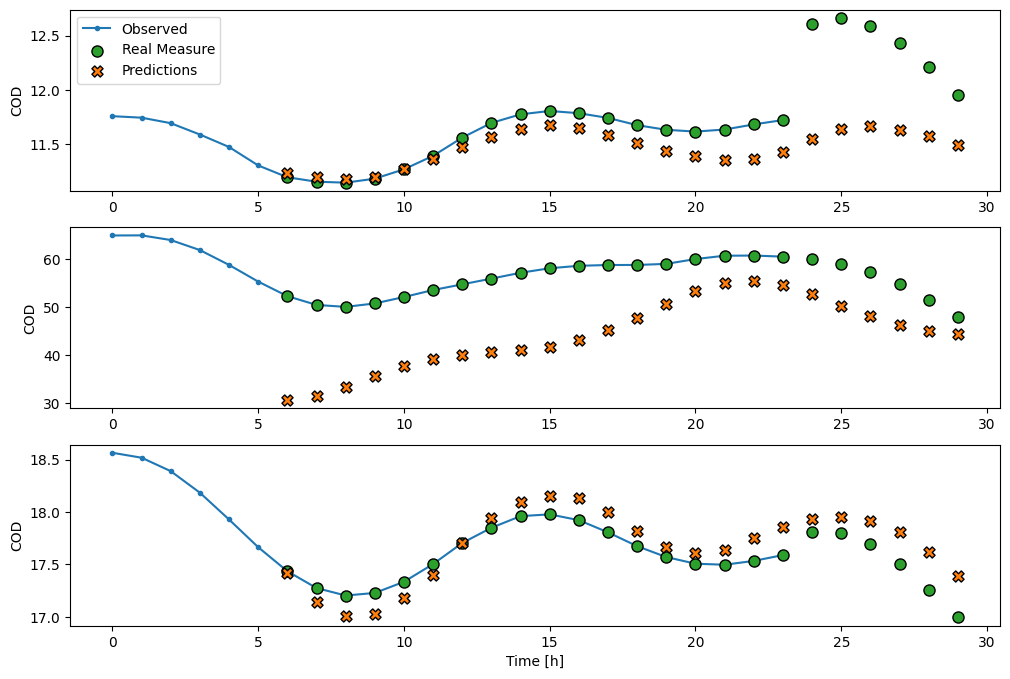

In [20]:
res = []
res_round = []

for inputs, labels in wide_window.test:
      labels = np.array(labels[:, :, -2])
      labels = labels*train_std['COD']+train_mean['COD']

      
      pred = multi_lstm_model(inputs)
      pred = np.array(pred[:, :, -2])
      pred = pred*train_std['COD']+train_mean['COD']

      for i in range(pred.shape[0]):
          res.append(compute_metrics(pred[i,:],labels[i,:].reshape(-1)))
          #res_round.append(compute_metrics(pred[i,:].round(),labels[i,:].reshape(-1).round()))

mean_res = np.mean(res, axis=0)
print(labels)
#mean_res_round = np.mean(res_round, axis=0)

print('----------------------------------------------------------------------')
print(mean_res)

wind_res = []
def plot_notscal(self, mean, std, wind_res, model=None, plot_col=targets[1], max_subplots=3):
  inputs, labels = self.example
  inputs_notscal = inputs*std+mean
  labels = labels*std+mean
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs_notscal[n, :, plot_col_index],
             label='Observed', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Real Measure', c='#2ca02c', s=64)
    if model is not None:
      preds = model(inputs)
      preds = preds*std+mean
      plt.scatter(self.label_indices, preds[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
      
      preds = np.array(preds[:, :, -2])

    #for i in range(preds.shape[0]):
     #     wind_res.append(compute_metrics(np.array(preds[i,:]),np.array(labels[i,:]).reshape(-1)))
    
    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot_notscal = plot_notscal
wide_window.plot_notscal(train_mean['COD'],train_std['COD'], wind_res, multi_lstm_model)

[[4.4402514 4.2172866 3.98086   3.7814715 3.6588366 3.6389751 3.7308307
  3.9325078 4.2139297 4.5290103 4.8193593 5.0398593 5.13362   5.1114197
  5.0080137 4.878909  4.7693458 4.7214456 4.740549  4.8139606 4.90654
  4.580452  4.560911  4.468459 ]
 [4.329015  4.129071  3.959274  3.8495884 3.8200147 3.8766403 4.01801
  4.2171874 4.435416  4.625259  4.751264  4.7952876 4.7642803 4.684206
  4.590551  4.5146666 4.478275  4.488519  4.5375986 4.6003222 4.6119537
  4.6016016 4.5261235 4.3878436]
 [7.287614  7.198452  7.084134  6.9868755 6.9367223 6.9408646 6.991234
  7.0603046 8.03592   8.111553  8.028914  7.8065352 7.4871445 7.1452217
  6.8544035 6.664009  6.6048164 6.697033  6.9267135 7.249436  7.6159177
  7.950113  8.188123  8.300456 ]]
----------------------------------------------------------------------
[ 0.85615032  1.1961045   0.09642481 -0.30649654  8.37433518  6.24795645]


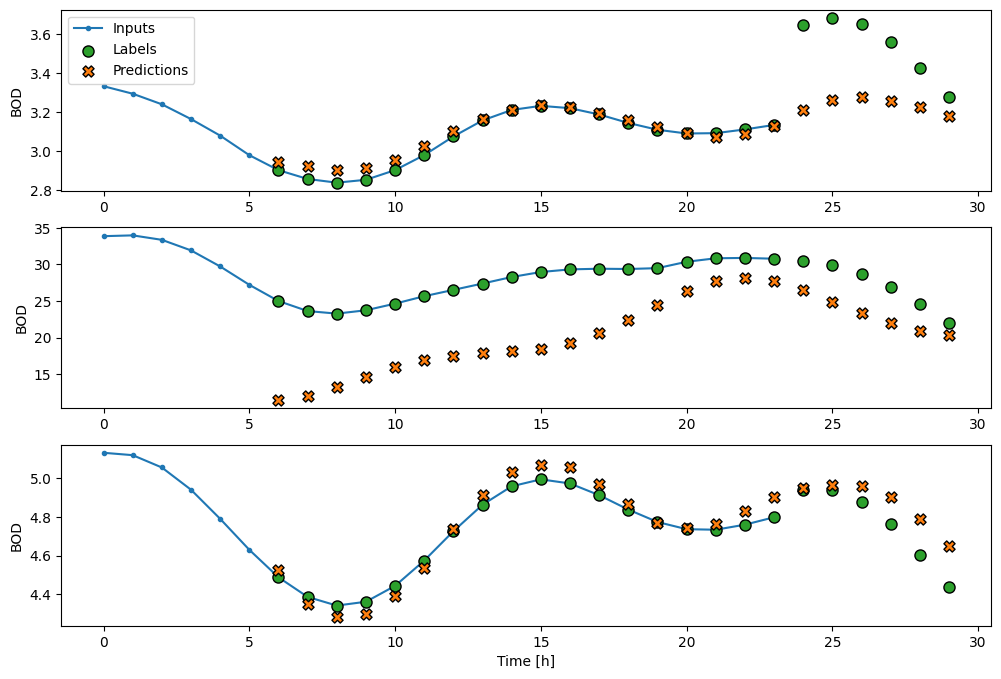

In [21]:
res = []
res_round = []

for inputs, labels in wide_window.test:
      labels = np.array(labels[:, :, -3])
      labels = labels*train_std['BOD']+train_mean['BOD']

      
      pred = multi_lstm_model(inputs)
      pred = np.array(pred[:, :, -3])
      pred = pred*train_std['BOD']+train_mean['BOD']

      for i in range(pred.shape[0]):
          res.append(compute_metrics(pred[i,:],labels[i,:].reshape(-1)))
          #res_round.append(compute_metrics(pred[i,:].round(),labels[i,:].reshape(-1).round()))

mean_res = np.mean(res, axis=0)
print(labels)
#mean_res_round = np.mean(res_round, axis=0)

print('----------------------------------------------------------------------')
print(mean_res)

wind_res = []
def plot_notscal(self, mean, std, wind_res, model=None, plot_col=targets[0], max_subplots=3):
  inputs, labels = self.example
  inputs_notscal = inputs*std+mean
  labels = labels*std+mean
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs_notscal[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      preds = model(inputs)
      preds = preds*std+mean
      plt.scatter(self.label_indices, preds[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
      
      preds = np.array(preds[:, :, -3])

    #for i in range(preds.shape[0]):
          #wind_res.append(compute_metrics(np.array(preds[i,:]),np.array(labels[i,:]).reshape(-1)))
    
    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot_notscal = plot_notscal
wide_window.plot_notscal(train_mean['BOD'],train_std['BOD'], wind_res, multi_lstm_model)

In [22]:
result_COD=[]
result_BOD=[]
result_TSS=[]

input=tf.stack([np.array(Total_df[0:24][:])])
pred=multi_lstm_model(input)

for i in range(24):
  a=(pred[0][i][0]).numpy()*train_std['BOD']+train_mean['BOD']
  b=(pred[0][i][1]).numpy()*train_std['COD']+train_mean['COD']
  c=(pred[0][i][2]).numpy()*train_std['TSS']+train_mean['TSS']
  result_BOD.append(a)
  result_COD.append(b)
  result_TSS.append(c)
for j in range(24,8640):
  input=tf.stack([np.array(Total_df[j-24+1:j+1][:])])
  pred=multi_lstm_model(input)
  a=(pred[0][23][0]).numpy()*train_std['BOD']+train_mean['BOD']
  b=(pred[0][23][1]).numpy()*train_std['COD']+train_mean['COD']
  c=(pred[0][23][2]).numpy()*train_std['TSS']+train_mean['TSS']
  result_BOD.append(a)
  result_COD.append(b)
  result_TSS.append(c)

In [23]:
input

<tf.Tensor: shape=(1, 24, 9), dtype=float64, numpy=
array([[[ 0.35247293,  0.43429475, -0.61963613, -0.60536748,
          0.35247293, -0.78846033, -0.52439156, -0.45570505,
         -0.05590949],
        [ 0.33302056,  0.43437889, -0.5993341 , -0.57840664,
          0.33302056, -0.77390023, -0.52758104, -0.45949591,
         -0.05671111],
        [ 0.18642418,  0.4343152 , -0.67167499, -0.40662869,
          0.18642418, -0.74213861, -0.54990502, -0.47693337,
         -0.07432791],
        [-0.08202636,  0.43442515, -0.65447798, -0.16973825,
         -0.08202636, -0.67507711, -0.5926292 , -0.50207955,
         -0.07383154],
        [-0.43138478,  0.43443479, -0.57237421,  0.10840059,
         -0.43138478, -0.57697833, -0.64841923, -0.53063408,
         -0.05610579],
        [-0.79390831,  0.43429515, -0.56476095,  0.4313261 ,
         -0.79390831, -0.47423848, -0.70816276, -0.56352123,
         -0.05662049],
        [-1.09144646,  0.43447988, -0.56102896,  0.70550337,
         -1.09144

In [24]:
Test['Effluent BOD ANN 6H']=result_BOD
Test['Effluent COD ANN 6H']=result_COD
Test['Effluent TSS ANN 6H']=result_TSS

print(Test)
with pd.ExcelWriter(save_path / 'output6H_256_72_72.xlsx') as writer:  
    Test.to_excel(writer, sheet_name='Sheet_name_1')

      SCENARIO 0: NO MALFUNCTIONS                Date  Influent Flow   
0                             NaN 2020-01-01 01:00:00    90602.84986  \
1                             NaN 2020-01-01 01:59:59    90108.06362   
2                             NaN 2020-01-01 03:00:00    86379.27025   
3                             NaN 2020-01-01 04:00:00    79551.02088   
4                             NaN 2020-01-01 04:59:59    70664.81649   
...                           ...                 ...            ...   
8635                          NaN 2020-12-25 19:59:59    76991.67167   
8636                          NaN 2020-12-25 21:00:00    75601.84415   
8637                          NaN 2020-12-25 22:00:00    76418.85176   
8638                          NaN 2020-12-25 22:59:59    78855.69696   
8639                          NaN 2020-12-26 00:00:00    81715.78604   

      Influent pH  Influent NNH4  Influent PPO4  Biofor DN Temperature   
0        7.699933        16.8012          1.230              